# Projection of political actors onto a scale of pro- vs anti-EU

In [101]:
# Make sure politician2vec is up to date
#%pip uninstall politician2vec -y
#%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

# Make sure to auto-reload politician2vec in case there are remote changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# Imports
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
# import multiprocessing
# available_workers = multiprocessing.cpu_count()
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

## Data

In [229]:
# Specify path to preprocessed dataset
test_data_path = 'data/clean/preprocessed_docs_2015_low.p'

parl_data = pd.read_pickle(test_data_path).query("party not in ['SIU', 'NQ', 'JF', 'SP', 'M', 'DD', 'UFG', 'KD']")
parl_data.shape

(156448, 6)

In [230]:
grouped_docs = parl_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])

In [231]:
# Load embedding
model_path = 'embedding_models/fastlearn_2015_low.txt'
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [232]:
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'Enhedslisten',
   4: 'Radikale Venstre',
   5: 'SF',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'UFG',
   9: 'Alternativet',
   10: 'Danmarksdemokraterne',
   11: 'Nye Borgerlige',
   12: 'Frie Grønne',
   13: 'Moderaterne',
   14: 'Kristendemokraterne'
}

In [233]:
colormap = { # TODO: COLLECT EVERYTHING IN ONE DICT/FRAME!!!!!
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [234]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

party_df['rank'] = party_df['party'].map(party_df['party'].value_counts())
party_df.loc[party_df['party'] == 'KF', 'rank'] = 16 # necessary due to slight inconsistency in the order in which parties are output...

party_labels = party_df.drop_duplicates(keep = 'first', subset = 'party').sort_values(by='rank', ascending=False)

partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

party_labels

party sizes before filtering (party 19 is "Other"):

[[ 0 54]
 [ 1 47]
 [ 2 37]
 [ 3 18]
 [ 4 16]
 [ 5 16]
 [ 6 15]
 [ 7 13]
 [ 8 11]
 [ 9  4]
 [10  3]]


,doc,party,snippet,color,full_name,rank
2,2,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,55
6,6,V,tak for ordet nu har vi jo talt rigtig meget o...,#1A4289,Anne Honoré Østergaard,47
0,0,DF,tak for det jeg er lidt forvirret på et højere...,#265BA4,Alex Ahrendtsen,37
32,32,EL,tak for det jeg vil gerne spørge ordføreren om...,#BF2850,Christian Juhl,18
9,9,SF,tak for det vi er flere her der har svære navn...,#B42D27,Anne Valentina Berthelsen,16
17,17,KF,tak for det tak for en fin ordførertale det da...,#24573E,Birgitte Bergman,16
4,4,RV,tak for en rigtig god tale det var også godt d...,#D82E8A,Andreas Steenberg,15
1,1,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13
28,28,ALT,tak for det nu sagde ordføreren i sin ordfører...,#75FB4C,Carolina Magdalene Maier,11
113,113,NB,jeg skal prøve at inddrage hr søren pape pouls...,#1E4B57,Lars Boje Mathiesen,4


In [235]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')
combined_hover

,doc,party,snippet,color,full_name,rank
0,0.0,DF,tak for det jeg er lidt forvirret på et højere...,#265BA4,Alex Ahrendtsen,37.0
1,1.0,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13.0
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,55.0
3,3.0,LA,først og fremmest skal man vel ønske færøerne ...,#E7B657,Anders Samuelsen,13.0
4,4.0,RV,tak for en rigtig god tale det var også godt d...,#D82E8A,Andreas Steenberg,15.0
...,...,...,...,...,...,...
240,NaN,RV,NaN,black,NaN,NaN
241,NaN,LA,NaN,black,NaN,NaN
242,NaN,ALT,NaN,black,NaN,NaN
243,NaN,NB,NaN,black,NaN,NaN


## Construction of scale

In [236]:
# Arithmetic mean of input vectors
def mean_vec(vecs):
    return np.mean(vecs, axis=0)

# manually implement cosine similarity between two vectors,
# since phrases are not added to the internal doc2vec model...
def calc_cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# get vectors for input word
def get_vec(word):
    idx = pol2vec_model.word_indexes[word]
    vec = pol2vec_model.word_vectors[idx]
    
    return vec

# Define function that takes two words (or n-grams),
# retrieves the corresponding vectors, and returns the cosine similarity
def get_cos_sim(input_words):
    idcs = [pol2vec_model.word_indexes[word] for word in input_words]
    vec1, vec2 = [pol2vec_model.word_vectors[idx] for idx in idcs]
    
    return calc_cos_sim(vec1, vec2)

In [237]:
from itertools import combinations
from tqdm.notebook import tqdm

class Subdimension:
    def __init__(self, present_words, absent_words):
        self.words = {'present': present_words, 'absent': absent_words}
        self.vecs = {'present': [get_vec(word) for word in present_words], 'absent': [get_vec(word) for word in absent_words]}
    
    def add_words(self, words, present = True):
        '''
        Manually add extra words and their vector representations to the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._add_word(word, present)
    
    def remove_words(self, words, present = True):
        '''
        Manually remove words and their vector representations from the subdimension.

        Parameters
        ----------
        words : list
            List of words to add to the subdimension.
        present : bool, optional
            Whether the words belong to the present or absent endpoint of the subdimension, by default True
        '''
        for word in words:
            self._remove_word(word, present)

    # Backend/helper functions below
    def _add_word(self, word, present = True): # TODO: Make it impossible to add the same word twice...
        self.words['present' if present else 'absent'].append(word)
        self.vecs['present' if present else 'absent'].append(self.get_vec(word))

    def _remove_word(self, word, present = True):
        remove_idx = self.words['present' if present else 'absent'].index(word)
        self.words['present' if present else 'absent'].remove(word)
        del self.vecs['present' if present else 'absent'][remove_idx]

    def calc_subdim_vecs(self):
        '''
        Return the arithmetic mean of both the "present" and the "absent"
        word sets (i.e. construct the endpoints of the subdimension).
        '''
        #return Politician2Vec._l2_normalize(mean_vec(self.vecs['present'])), Politician2Vec._l2_normalize(mean_vec(self.vecs['absent']))
        return mean_vec(self.vecs['present']), mean_vec(self.vecs['absent']) # TODO: Figure out whether or not to normalise!
    
    def optimise_subdim(self, present=True, min_size=2, max_size=None, replace=True):
        '''
        Optimise the subdimension by finding the word set that maximises the average cosine similarity

        Parameters
        ----------
        present : bool, optional
            Whether to optimise the "present" or "absent" endpoint of the subdimension, by default True
        min_size : int, optional
            Minimum number of words in the word set, by default 2
        max_size : int, optional
            Maximum number of words in the word set, by default None (i.e. no limit)
        replace : bool, optional
            Whether to replace the original word set with the optimised one, by default True

        Returns
        -------
        best_group : list
            The optimised word set.
        best_labels : list
            The corresponding word labels.
        best_sim : float
            The average cosine similarity of the optimal word set.
        '''
        
        best_group, best_labels, best_sim = self.optimise_group_similarity(
            vectors=self.vecs['present' if present else 'absent'],
            labels=self.words['present' if present else 'absent'],
            min_size=min_size,
            max_size=max_size
            )
        
        if replace:
            self.words['present' if present else 'absent'] = best_labels
            self.vecs['present' if present else 'absent'] = best_group
        
        print('Best avg. cosine similarity:', best_sim)
        
        return best_group, best_labels
    
    @staticmethod
    def get_vec(word):
        '''Retrieve the vector representation of a given word from the politician2vec model.'''
        idx = pol2vec_model.word_indexes[word]
        vec = pol2vec_model.word_vectors[idx]

        return vec
    
    @staticmethod
    def mean_vec(vecs):
        return np.mean(vecs, axis=1)

    @staticmethod
    def group_cosine_similarity(vectors):
        '''
        Calculates the average cosine similarity between all pairs of vectors in a group.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.

        Returns
        -------
        float: The average cosine similarity between all pairs of vectors in the group.
       '''

        # calculate the pairwise cosine similarities
        pairwise_sims = []
        for v1, v2 in combinations(vectors, 2):
            sim = calc_cos_sim(v1,v2)
            pairwise_sims.append(sim)

        # calculate the average cosine similarity
        avg_sim = np.mean(pairwise_sims)

        return avg_sim

    def optimise_group_similarity(self, vectors, labels, min_size, max_size):
        '''
        Optimizes the average cosine similarity of a group of vectors byiteratively removing and
        including different combinations.

        Parameters
        ----------
        vectors (list): A list of 300-dimensional word vectors.
        labels (list): A list of labels for the vectors.
        min_size (int): The minimum size of the group to consider. Default is 2.
        max_size (int): The maximum size of the group to consider. Default is None (use all vectors).

        Returns
        -------
        list: The optimized group of vectors that maximizes the average cosine similarity.
        list: The labels of the vectors in the optimized group.
        float: The maximum average cosine similarity achieved by the optimized group.
        '''

        # set max_size to len(vectors) if not specified
        if max_size is None:
            max_size = len(vectors)

        # initialize the best group, labels, and similarity
        best_group = None
        best_labels = None
        best_sim = 0.0

        # iterate over all possible group sizes
        for size in tqdm(range(min_size, max_size+1)):
            
            # iterate over all possible combinations of vectors
            for group_idx in combinations(range(len(vectors)), size):
                
                # get the vectors and labels for the current group
                group = [vectors[i] for i in group_idx]
                group_labels = [labels[i] for i in group_idx]
                
                # calculate the average cosine similarity of the group
                sim = self.group_cosine_similarity(group)
                
                # update the best group, labels, and similarity if a new maximum is found
                if sim > best_sim:
                    best_group = group
                    best_labels = group_labels
                    best_sim = sim

        return best_group, best_labels, round(best_sim, ndigits=3)


In [238]:
# TODO: FIX PARTY INDECES!!!!!!! THIS IS WHY EL SEEMS TO BE POSITIONED INCORRECTLY........
# TODO: Try projecting both parties and politicians
# TODO: Stick to the planned keyword expansion procedure!
# TODO: Deterministic optimisation procedure or not???
# TODO: Include exploration of n-gramsin keyword expansion functionality

pro_eu_words = [
    'fælles eu-forsvar',
    #'fælles eu-regler',
    'fællesskab eu',
    #'følger eus',
    #'gældende eu-regler',
    'hjertet eu',
    'kræfter eu',
    'resten eu',
    'samarbejde eu',
    'tilhængere eu',
    #'fri bevægelighed'
    #'tværs eu',
    'uden eu',
    #'vores eu-retlige',
    # 'aktivt eu',
    'andre eu-borgere',
    'union',
    #'elsker eu', # reverse?
    'opgør forsvarsforbeholdet'
    ]

anti_eu_words = [
    #'eu blander',
    #'eu bestemmer',
    'eu tillader',
    #'folkebevægelsen eu',
    'imod eu',
    #'imod eus',
    #'kommer eu-hær',
    'krav eu', # reverse?
    'kritisk eu',
    #'styr eu',
    'magt eu',
    #'frihandelsaftale eu',
    'snævrere union',
    #'nuværende form',
    #'melde eu',
    'mindre eu',
    'modstander eu',
    'nede eu',
    'nogen eu-hær',
    'skærpet eu-kurs',
    #'træde eu',
    'udfordre eu',
    'udmeldelse eu',
    #'ønsker eu-hær', # reverse?
    #'beføjelser eu', # reverse?
    'begejstret eu', # reverse?
    'vores forsvarsforbehold' # reverse?
    ]


In [239]:
# write pol2vec_model.vocab to txt
with open('pol2vec_model_vocab_low.txt', 'w') as f:
    for word in pol2vec_model.vocab:
        f.write(word + '\n')

In [240]:
pol2vec_model.model.wv.most_similar(positive = ['mindsteløn'], topn = 15)

[('mindstelønnen', 0.6030590534210205),
 ('kontanthjælpen', 0.4436953365802765),
 ('lønninger', 0.41297632455825806),
 ('kompensationsgraden', 0.411327600479126),
 ('løn', 0.41082558035850525),
 ('kontanthjælp', 0.40693965554237366),
 ('kontanthjælpssystem', 0.38234150409698486),
 ('konfliktretten', 0.3571695387363434),
 ('lønningerne', 0.35496240854263306),
 ('enlig', 0.35426560044288635),
 ('overenskomsten', 0.34932926297187805),
 ('arbejdsmarkedet', 0.3457309603691101),
 ('fagbevægelse', 0.34469032287597656),
 ('arbejdsmarkedets', 0.333700954914093),
 ('job', 0.3322090804576874)]

In [241]:
eu_dimension = Subdimension(
    present_words=pro_eu_words,
    absent_words=anti_eu_words
    )

In [242]:
print(eu_dimension.words)
print(len(eu_dimension.vecs['present']))

{'present': ['fælles eu-forsvar', 'fællesskab eu', 'hjertet eu', 'kræfter eu', 'resten eu', 'samarbejde eu', 'tilhængere eu', 'uden eu', 'andre eu-borgere', 'union', 'opgør forsvarsforbeholdet'], 'absent': ['eu tillader', 'imod eu', 'krav eu', 'kritisk eu', 'magt eu', 'snævrere union', 'mindre eu', 'modstander eu', 'nede eu', 'nogen eu-hær', 'skærpet eu-kurs', 'udfordre eu', 'udmeldelse eu', 'begejstret eu', 'vores forsvarsforbehold']}
11


In [243]:
# TODO: Optimise this brute-force algorithm, since it's way too slow for many vecs at once
# Pro:
best_vecs, best_words = eu_dimension.optimise_subdim(present=True, min_size=6, max_size=10, replace=True)
print(best_words)

# Anti:
best_vecs, best_words = eu_dimension.optimise_subdim(present=False, min_size=6, max_size=10, replace=True)
print(best_words)

  0%|          | 0/5 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.737
['fællesskab eu', 'kræfter eu', 'resten eu', 'samarbejde eu', 'uden eu', 'andre eu-borgere']


  0%|          | 0/5 [00:00<?, ?it/s]

Best avg. cosine similarity: 0.755
['imod eu', 'krav eu', 'snævrere union', 'mindre eu', 'nede eu', 'udmeldelse eu']


In [244]:
pro_eu, anti_eu = eu_dimension.calc_subdim_vecs()

eu_axis = pro_eu - anti_eu

## Plotting and validation

In [245]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.patheffects as pe
plt.rcParams['figure.dpi'] = 250

# define a funciton that takes a column from df_val and plots it as as sorted bar chart
def plot_bar(df, col, title, xlabel, ylabel, color):
    df = df.sort_values(col, ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(df['Partyabb'], rescale(df[col]), color=df[color])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# define a funciton to plot the same data as a 1-dimensional dot plot
def plot_dot(df, col, title, xlabel, color, jitter=False):
    plt.figure(figsize=(15, 2.5))
    if jitter:
        y_jitter = np.random.normal(scale=0.001, size=len(df[col]))
        plt.scatter(rescale(df[col]), y_jitter, color='white')
    else:
        plt.scatter(rescale(df[col]), np.zeros_like(rescale(df[col])), color=df[color])

    # add party labels
    for i, txt in enumerate(df['Partyabb']):
            plt.text(rescale(df[col])[i], y_jitter[i], txt, ha='center', va='center', fontsize=20, color=df[color][i], weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black')])
    
    plt.grid(False)
    plt.box(False)
    plt.yticks([])
    
    plt.axhline(y=0, color='darkgrey', linewidth=1)
    plt.axvline(x=0, color='darkgrey', linewidth=1, linestyle=':')

    plt.ylim(-0.005, 0.005)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# define a function that takes a variable and rescales it to the range -1 to 1
def rescale(var):
    var = (var - var.min()) / (var.max() - var.min())
    var = 2 * var - 1
    return var

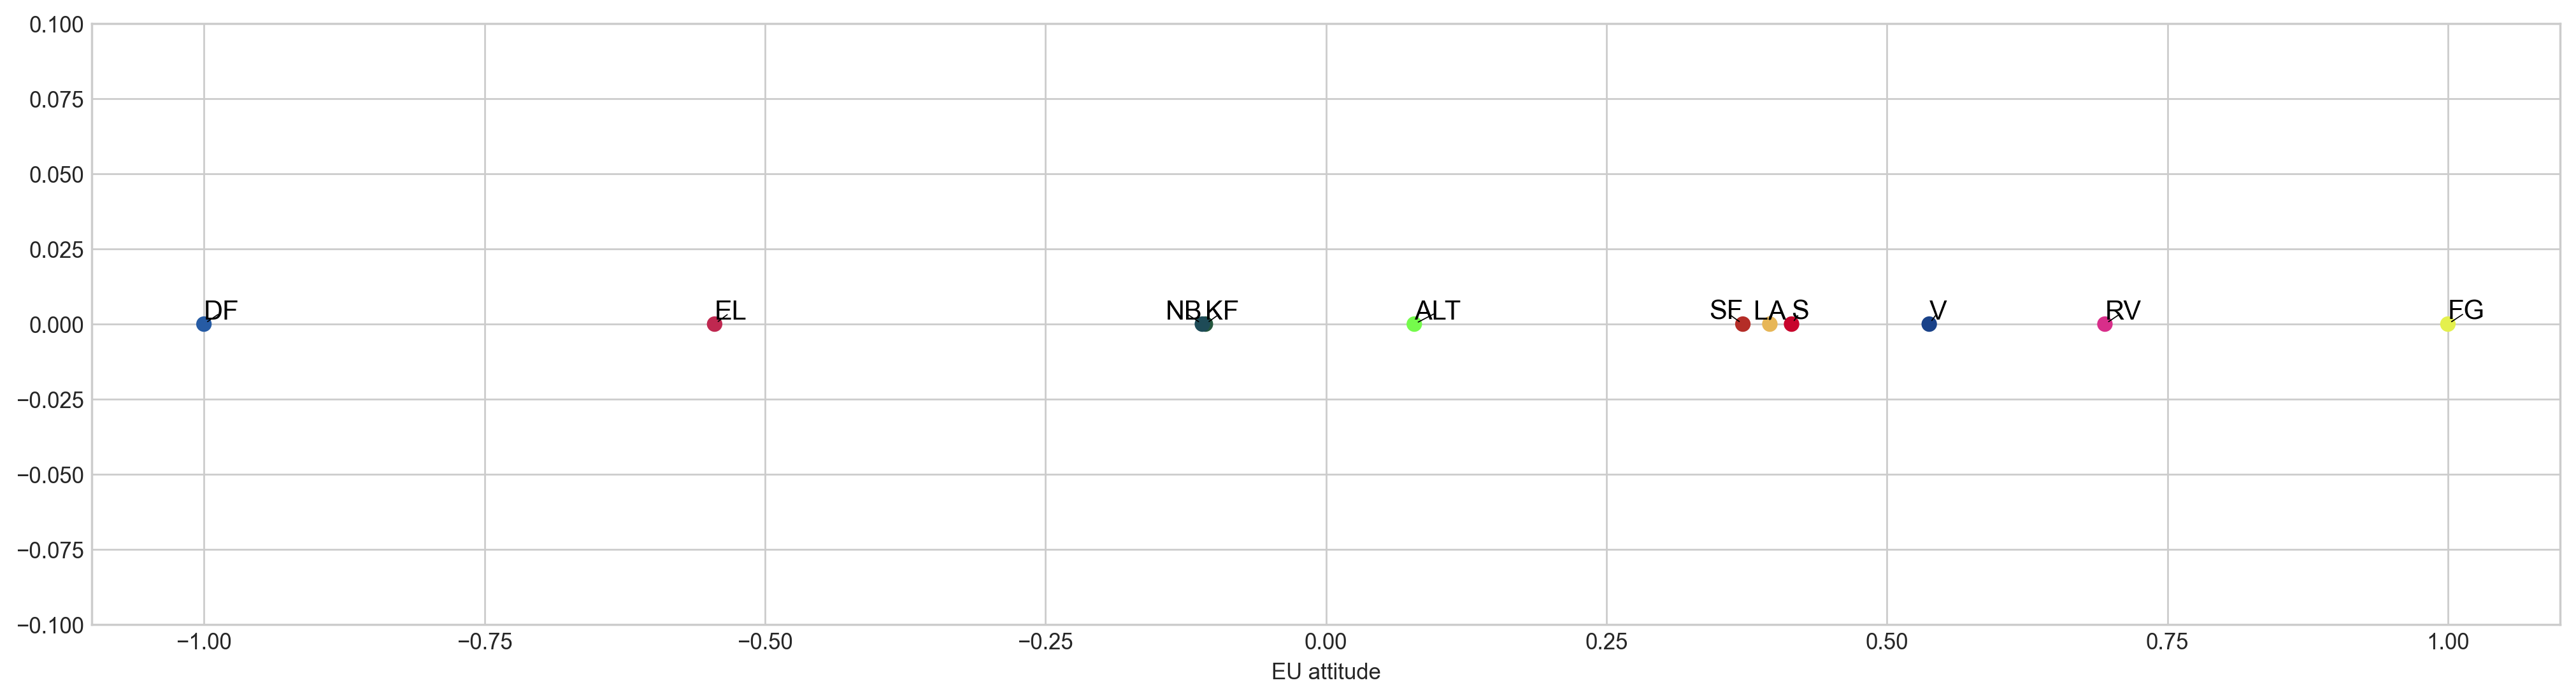

In [246]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
colorlist = combined_hover.dropna()['color']

# project politicians onto each subdimension
proj_dim = np.dot(pol2vec_model.party_vectors, eu_axis)

# rescale subdim to (-1, 1)
proj_dim = (proj_dim - np.min(proj_dim)) / (np.max(proj_dim) - np.min(proj_dim))*2-1

# create 3x1 subplot
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# plot projection onto first subdimension
ax.scatter(proj_dim, np.zeros_like(proj_dim), c=party_labels['color'])
ax.set_xlabel('EU attitude')
ax.set_ylim(-0.1, 0.1)

# add party labels to each of the subplots without adjusting text positions
for i, party in enumerate(party_labels['party']):
    ax.text(proj_dim[i], 0, party, color='black', size=12)

# adjust text positions to avoid overlapping
adjust_text([ax.texts[i] for i in range(len(ax.texts))], ax=ax, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.show()

In [247]:
parties = ['S', 'RV', 'KF', 'SF', 'DF', 'V', 'EL', 'LA', 'ALT']
gns = [8.1, 8.2, 7.3, 5.9, 2.4, 7.8, 3.5, 6.2, 5.5]
gns = (gns - np.min(gns)) / (np.max(gns) - np.min(gns))*2-1

df_test = pd.DataFrame(zip(parties, gns), columns=['party', 'eu_avg'])

### Expert survey validation

In [248]:
df_val = pd.read_excel('data/validation.xlsx')[['Partyabb', 'PG_eu_anti_pro']]

In [249]:
df_plot = df_test.merge(df_val, left_on='party', right_on='Partyabb', how='left')

# rescale PG_eu_anti_pro to (-1, 1)
df_plot['PG_eu'] = (df_plot['PG_eu_anti_pro'] - np.min(df_plot['PG_eu_anti_pro'])) / (np.max(df_plot['PG_eu_anti_pro']) - np.min(df_plot['PG_eu_anti_pro']))*2-1

In [250]:
# map party positions and colours to df_test
df_plot = df_plot.merge(party_labels, on='party', how='outer')[['party', 'eu_avg', 'PG_eu', 'color', 'rank']].sort_values(by='rank', ascending=False).reset_index(drop=True)
df_plot['pos'] = proj_dim

In [251]:
df_plot

,party,eu_avg,PG_eu,color,rank,pos
0,S,0.965517,0.602551,#C8042C,55,0.415021
1,V,0.862069,1.000000,#1A4289,47,0.537723
2,DF,-1.000000,-0.953697,#265BA4,37,-1.000000
3,EL,-0.620690,-1.000000,#BF2850,18,-0.544847
4,KF,0.689655,0.689229,#24573E,16,0.371611
5,SF,0.206897,-0.353749,#B42D27,16,-0.107422
6,RV,1.000000,0.709229,#D82E8A,15,0.694303
7,LA,0.310345,0.918602,#E7B657,13,0.395661
8,ALT,0.068966,0.370637,#75FB4C,11,0.078761
9,NB,NaN,NaN,#1E4B57,4,-0.110134


In [252]:
df_plot = df_plot.dropna()
df_plot['pos'] = (df_plot['pos'] - np.min(df_plot['pos'])) / (np.max(df_plot['pos']) - np.min(df_plot['pos']))*2-1 # rescale after removing NB and FG?

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.9401800226557099, 0.00016254239539588447)


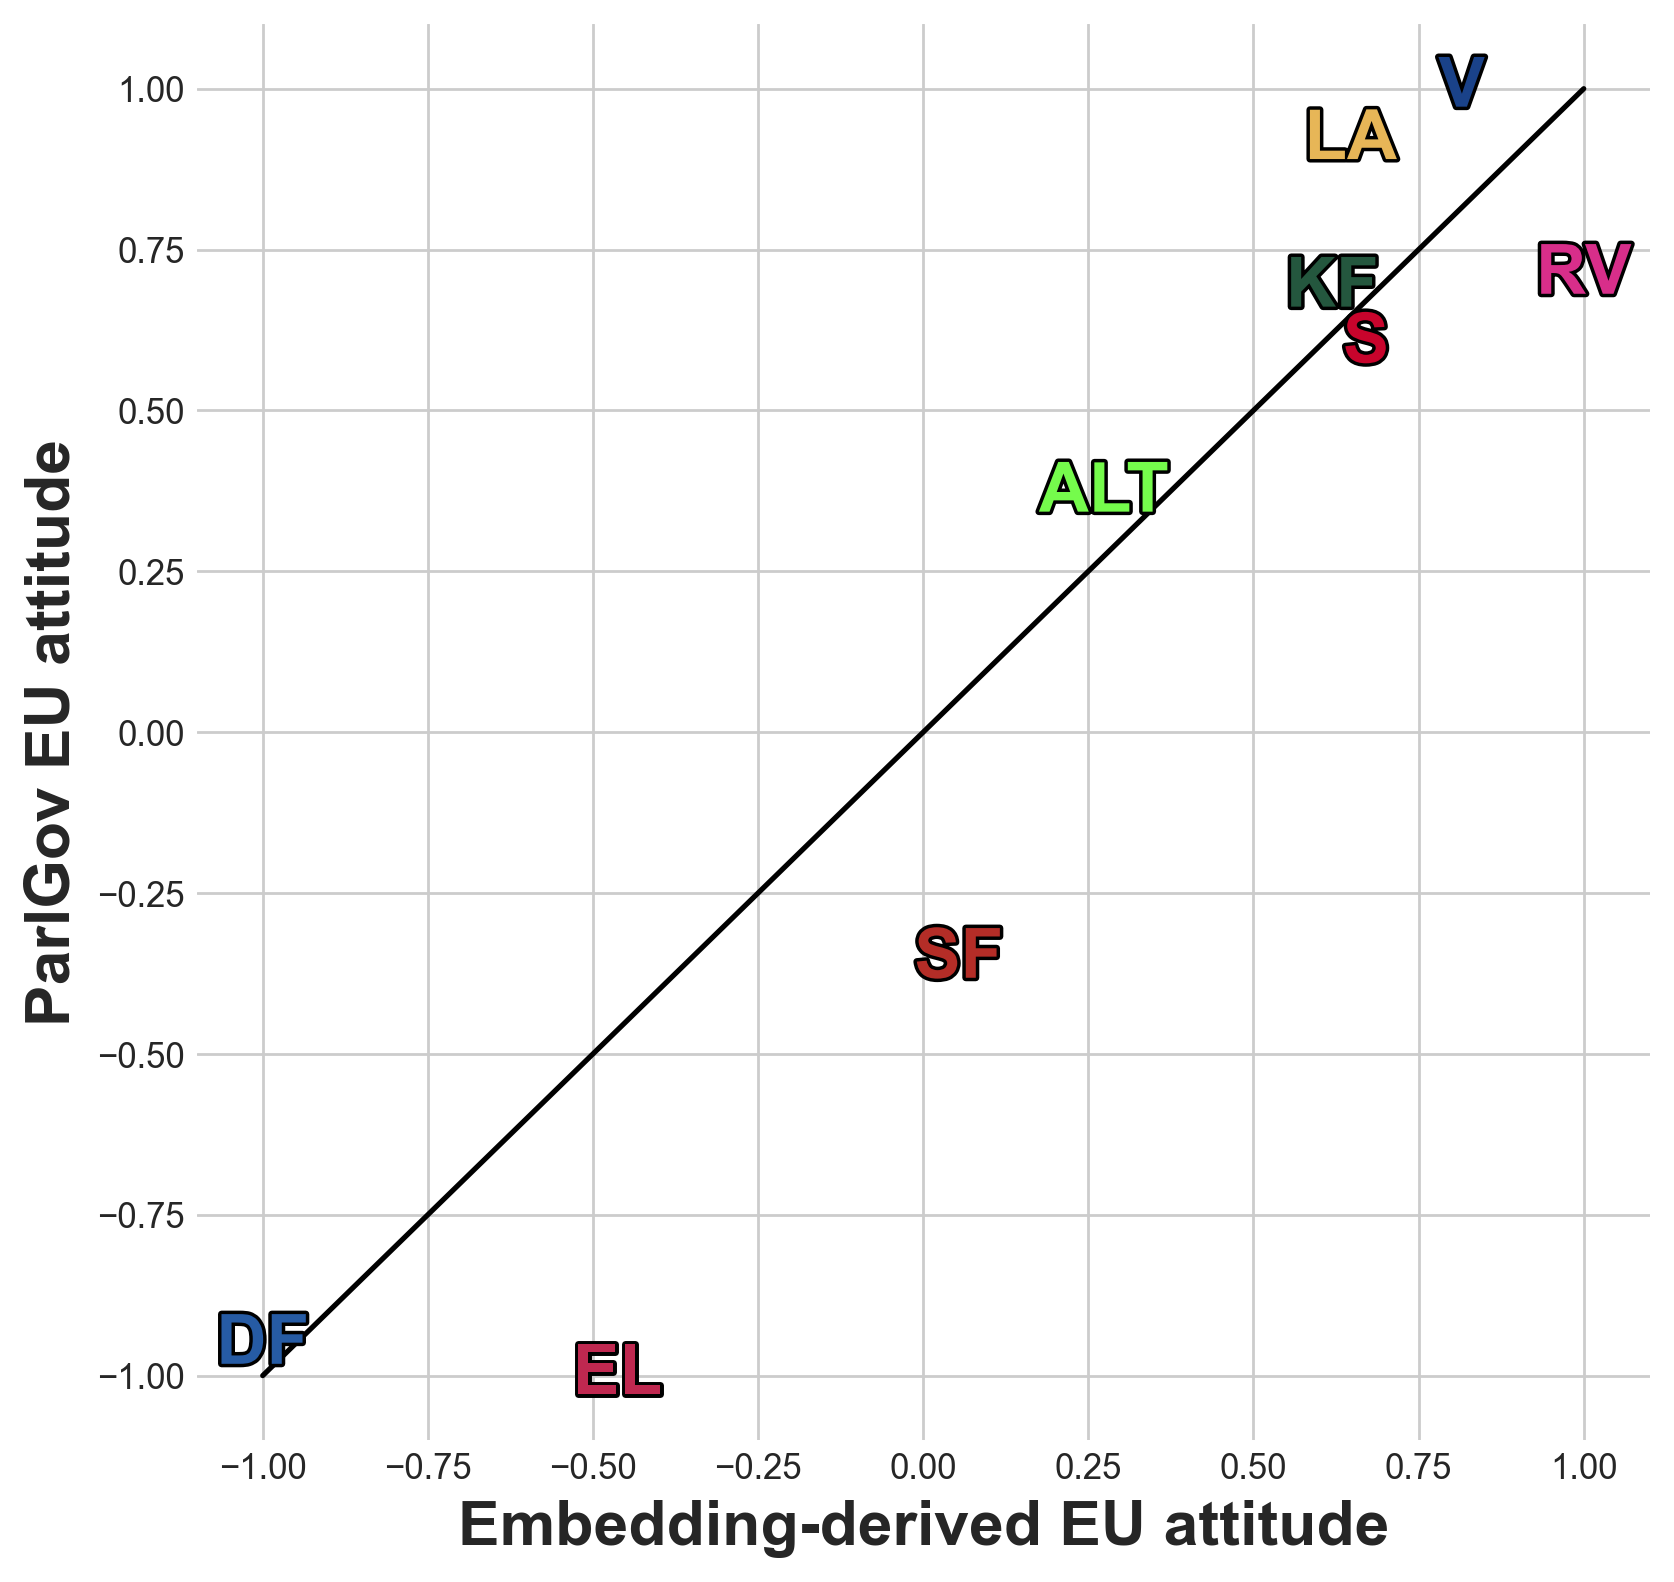

In [327]:
#comp_metric = 'eu_avg'
comp_metric = 'PG_eu'

# pearson's r of pos and PG_eu
from scipy.stats import pearsonr
print(pearsonr(df_plot['pos'], df_plot[comp_metric]))

# scatter pos and PG_eu
plt.figure(figsize=(7.5, 7.5))
plt.scatter(df_plot['pos'], df_plot[comp_metric], color='none')
plt.xlabel('Embedding-derived EU attitude', weight='bold', size=18)
plt.ylabel('ParlGov EU attitude', weight='bold', size=18)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# add regression line
# from scipy.stats import linregress
# slope, intercept, r_value, p_value, std_err = linregress(df_plot['pos'], df_plot[comp_metric])
# plt.plot(df_plot['pos'], intercept + slope*df_plot['pos'], 'black')

# draw line from -1,-1 to 1,1
plt.plot([-1, 1], [-1, 1], 'black')

plt.box(False)

# add party labels
for i, txt in enumerate(df_plot['party']):
    plt.text(
        df_plot['pos'][i],
        df_plot[comp_metric][i],
        txt,
        ha='center',
        va='center',
        fontsize=20,
        color=df_plot['color'][i],
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground='black')]
        )

plt.show()


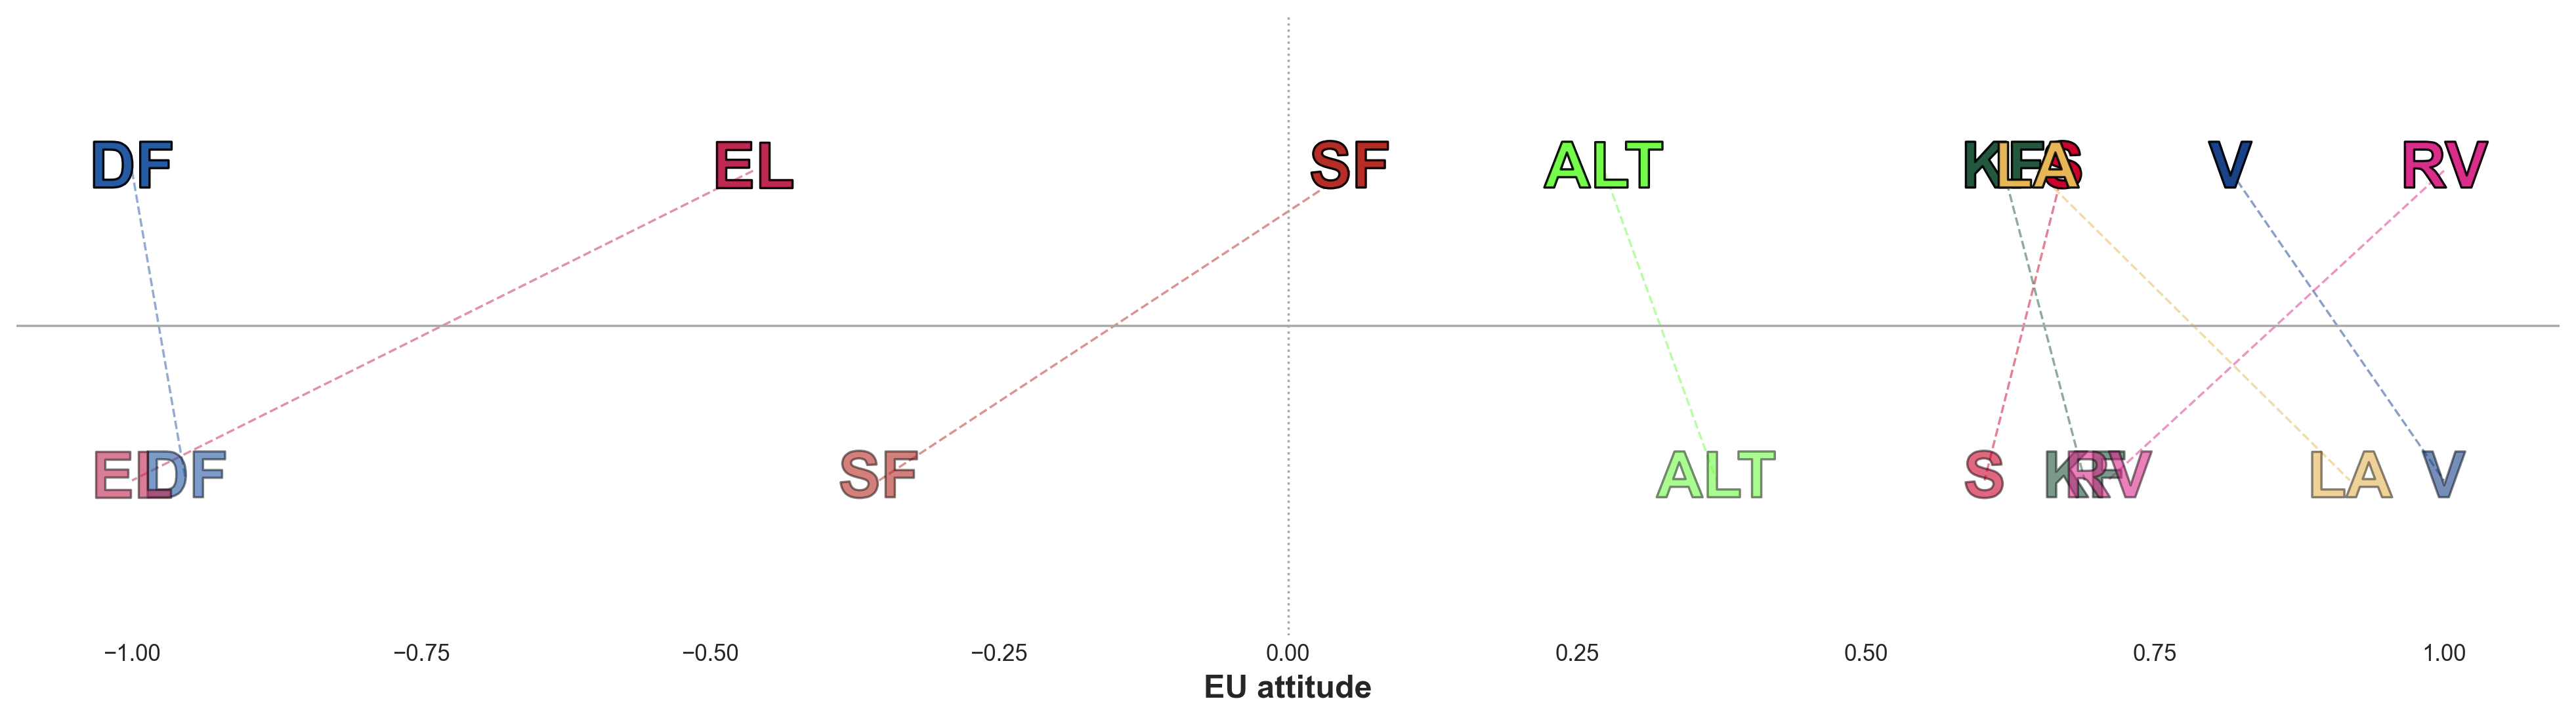

In [311]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.set_xlabel('EU attitude', size = 14, weight = 'bold')

ax.scatter(df_plot['pos'], np.zeros_like(df_plot['pos']), s=50, alpha=0.75, color='none')
ax.scatter(df_plot[comp_metric], np.zeros_like(df_plot[comp_metric]), s=50, alpha=0.75, color='none')

# # add party labels
for i, txt in enumerate(df_plot['party']):
    ax.text(df_plot['pos'][i], .01, txt, ha='center', va='center', fontsize=28, color=df_plot['color'][i], alpha=.2, weight='bold', path_effects=[pe.withStroke(linewidth=1, foreground='black', alpha=1)])

# # add party labels
for i, txt in enumerate(df_plot['party']):
    ax.text(df_plot[comp_metric][i], -.01, txt, ha='center', va='center', fontsize=28, color=df_plot['color'][i], alpha=.2, weight='bold', path_effects=[pe.withStroke(linewidth=1, foreground='black', alpha=.5)])

# for i, txt in enumerate(df_test['party']):
#     ax.text(rescale(df_test['V4_scale'])[i], rescale(df_test['value'])[i], txt, ha='center', va='center', fontsize=12, color=df_test['color'][i], alpha=1, weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black', alpha=1)])

# draw line segment between pos and eu_avg for each party
for i in range(len(df_plot)):
    ax.plot([df_plot['pos'][i], df_plot[comp_metric][i]], [0.01, -0.01], color=df_plot['color'][i], alpha=.5, linewidth=1, linestyle='--')

# add vline to plot
ax.axvline(x=0, color='darkgrey', linestyle=':', linewidth=1)
ax.axhline(y=0, color='darkgrey', linestyle='-', linewidth=1)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_yticks([])
ax.grid(False)

# set ylim
ax.set_ylim(-0.02, 0.02)

# Show the plot
plt.show()

In [312]:
# Pearson correlation between pos and comp_metric
from scipy.stats import pearsonr
print(pearsonr(df_plot['pos'], df_plot[comp_metric]))

(0.9401800226557099, 0.00016254239539588447)


In [313]:
# count number of documents per party
df_plot['count'] = df_plot['party'].map(parl_data['party'].value_counts(normalize=True))

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [314]:
# Standard OLS regression of pos and comp_metric
import statsmodels.api as sm
X = df_plot['pos']
y = df_plot[comp_metric]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  PG_eu   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     53.31
Date:                Fri, 05 May 2023   Prob (F-statistic):           0.000163
Time:                        22:07:48   Log-Likelihood:               -0.36161
No. Observations:                   9   AIC:                             4.723
Df Residuals:                       7   BIC:                             5.118
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1062      0.105     -1.010      0.3

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


In [315]:
# Conduct WLS regression of pos and comp_metric
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

X = df_plot['pos']
X = sm.add_constant(X)

y = df_plot[comp_metric]

mod_wls = sm.WLS(y, X, weights=1/(df_plot['count']))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  PG_eu   R-squared:                       0.845
Model:                            WLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     38.26
Date:                Fri, 05 May 2023   Prob (F-statistic):           0.000452
Time:                        22:07:49   Log-Likelihood:               -0.95687
No. Observations:                   9   AIC:                             5.914
Df Residuals:                       7   BIC:                             6.308
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1072      0.117     -0.919      0.3

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


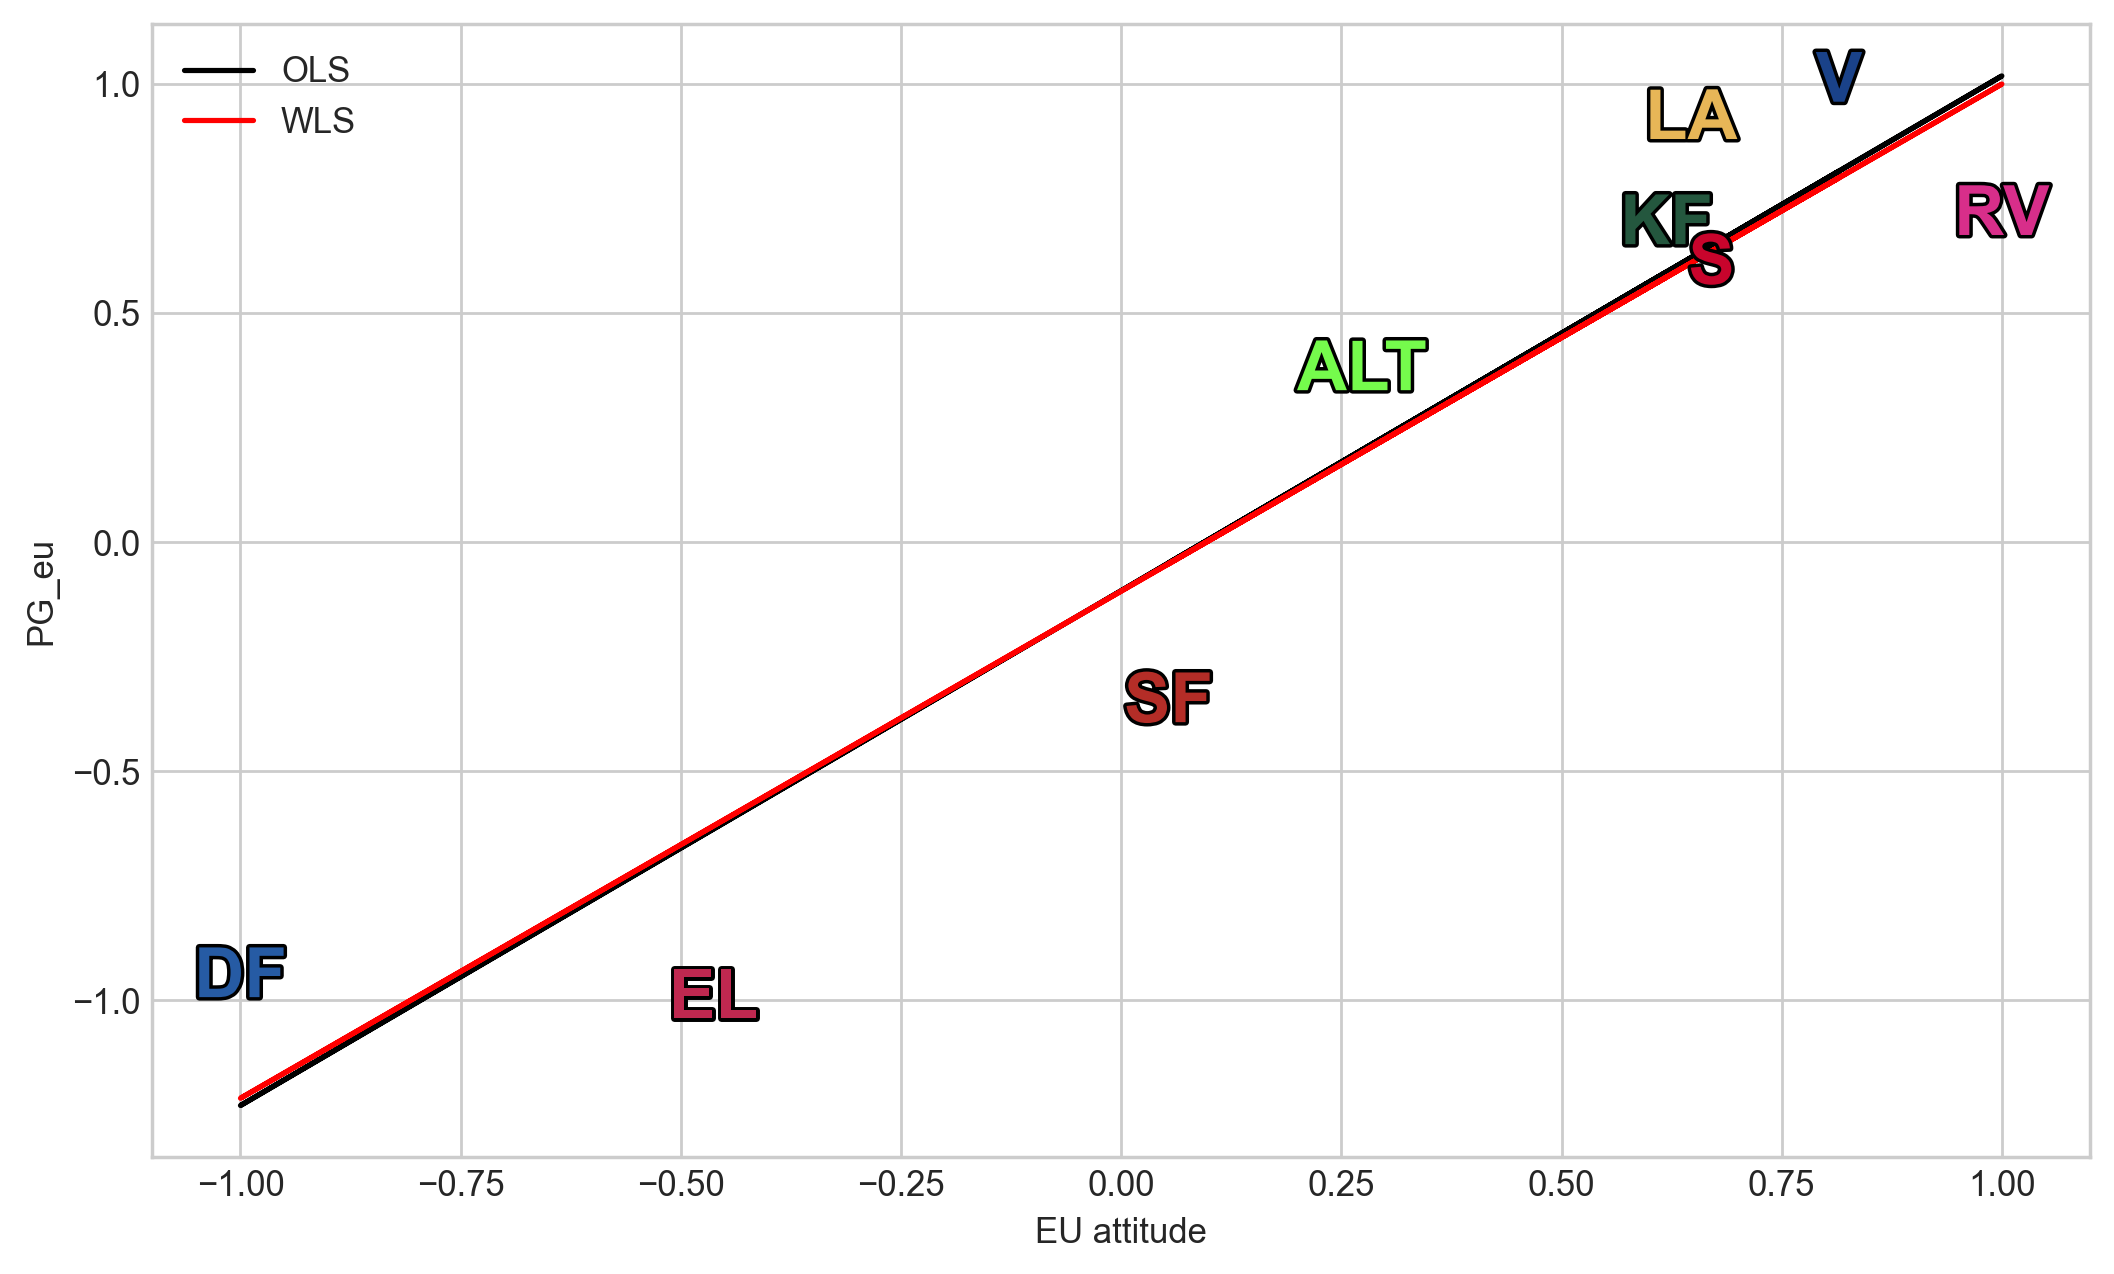

In [316]:
# create scatterplot of pos and comp_metric
plt.figure(figsize=(10, 6))
plt.scatter(df_plot['pos'], df_plot[comp_metric], color='none')
plt.xlabel('EU attitude')
plt.ylabel(comp_metric)

# overlay regression line from OLS and WLS
plt.plot(df_plot['pos'], predictions, 'black', label='OLS')

plt.plot(df_plot['pos'], res_wls.fittedvalues, 'r', label='WLS')

plt.legend()

# add party labels
for i, txt in enumerate(df_plot['party']):
    plt.text(df_plot['pos'][i], df_plot[comp_metric][i], txt, ha='center', va='center', fontsize=20, color=df_plot['color'][i], weight='bold', path_effects=[pe.withStroke(linewidth=2, foreground='black')])

plt.show()

### Candidate test validation (DR)

In [317]:
df_scales = pd.read_pickle('validation/dr/df_scales.p')

In [318]:
polvecs = pol2vec_model.document_vectors
polvecs.shape

(234, 300)

In [319]:
# project polvecs onto EU dimension
proj_dim = np.dot(polvecs, eu_axis)
proj_dim.shape

(234,)

In [320]:
eu_val = combined_hover.dropna()
eu_val['eu_att'] = proj_dim
eu_val.head()

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doc,party,snippet,color,full_name,rank,eu_att
0,0.0,DF,tak for det jeg er lidt forvirret på et højere...,#265BA4,Alex Ahrendtsen,37.0,-0.009697
1,1.0,LA,tak for det og tak for den fine udtale af efte...,#E7B657,Alex Vanopslagh,13.0,-0.003876
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,#C8042C,Anders Kronborg,55.0,-0.017610
3,3.0,LA,først og fremmest skal man vel ønske færøerne ...,#E7B657,Anders Samuelsen,13.0,0.038045
4,4.0,RV,tak for en rigtig god tale det var også godt d...,#D82E8A,Andreas Steenberg,15.0,-0.011049


In [321]:
eu_val_merged = eu_val.drop(columns=['color']).merge(df_scales, left_on='full_name', right_on='fullname', how='inner')

In [265]:
eu_val_merged

,doc,party_x,snippet,full_name,rank,eu_att,fullname,party_y,dk_out_eu,dk_up_def,dk_de_border,asyl_out_eu,color,index
0,0.0,DF,tak for det jeg er lidt forvirret på et højere...,Alex Ahrendtsen,37.0,-0.009697,Alex Ahrendtsen,DF,5.0,5.0,5.0,5.0,#265BA4,1.00
1,1.0,LA,tak for det og tak for den fine udtale af efte...,Alex Vanopslagh,13.0,-0.003876,Alex Vanopslagh,LA,2.0,5.0,1.0,4.0,#E7B657,0.25
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,Anders Kronborg,55.0,-0.017610,Anders Kronborg,S,1.0,5.0,2.0,4.0,#C8042C,0.00
3,4.0,RV,tak for en rigtig god tale det var også godt d...,Andreas Steenberg,15.0,-0.011049,Andreas Steenberg,RV,1.0,4.0,1.0,1.0,#D82E8A,0.00
4,5.0,S,tak for det venstre er jo virkelig gode til fl...,Ane Halsboe-Jørgensen,55.0,0.029614,Ane Halsboe-Jørgensen,S,1.0,5.0,4.0,5.0,#C8042C,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,223.0,S,ordføreren konstaterede jo lige før at han stå...,Trine Bramsen,55.0,-0.026432,Trine Bramsen,S,1.0,5.0,4.0,5.0,#C8042C,0.00
140,225.0,V,tak for de mange bemærkninger der er kommet ti...,Troels Lund Poulsen,47.0,-0.013204,Troels Lund Poulsen,V,1.0,5.0,4.0,4.0,#1A4289,0.00
141,229.0,ALT,mange tak jeg vil gerne spørge ordføreren om h...,Ulla Sandbæk,11.0,0.019389,Ulla Sandbæk,ALT,1.0,4.0,1.0,1.0,#75FB4C,0.00
142,232.0,S,tak for det nu insisterer ordføreren meget på ...,Yildiz Akdogan,55.0,0.005040,Yildiz Akdogan,S,1.0,4.0,2.0,2.0,#C8042C,0.00


In [266]:
weight = parl_data['full_name'].value_counts(normalize=True)
eu_val_merged['weight'] = eu_val_merged['full_name'].map(weight)
eu_val_sub = eu_val_merged.loc[eu_val_merged['weight'] > 0]

In [267]:
eu_val_sub['eu_index'] = (
    eu_val_sub['dk_out_eu'] #+
    #eu_val_sub['dk_de_border'] +
    #eu_val_sub['dk_up_def']
    ) / 1

# recscale eu_index to 0, 1
eu_val_sub['eu_att'] = (eu_val_sub['eu_att'] - np.min(eu_val_sub['eu_att'])) / (np.max(eu_val_sub['eu_att']) - np.min(eu_val_sub['eu_att']))

# recode eu_index so -1 is -1, and all others are 1
eu_val_sub['eu_index'] = eu_val_sub['eu_index'].apply(lambda x: 1 if x < 3 else 0)

In [268]:
eu_val_sub['eu_index'].value_counts()

1    128
0     16
Name: eu_index, dtype: int64

In [269]:
#logistic regression of eu_index on eu_att
import statsmodels.api as sm
logit_model=sm.Logit(eu_val_sub['eu_index'], eu_val_sub['eu_att'])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.314052
         Iterations 7
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.100  
Dependent Variable: eu_index         AIC:              92.4469
Date:               2023-05-05 21:55 BIC:              95.4167
No. Observations:   144              Log-Likelihood:   -45.223
Df Model:           0                LL-Null:          -50.232
Df Residuals:       143              LLR p-value:      nan    
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     7.0000                                    
----------------------------------------------------------------
           Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
eu_att     4.6717     0.6513   7.1726   0.0000   3.3952   5.9483



<AxesSubplot:xlabel='eu_att', ylabel='eu_index'>

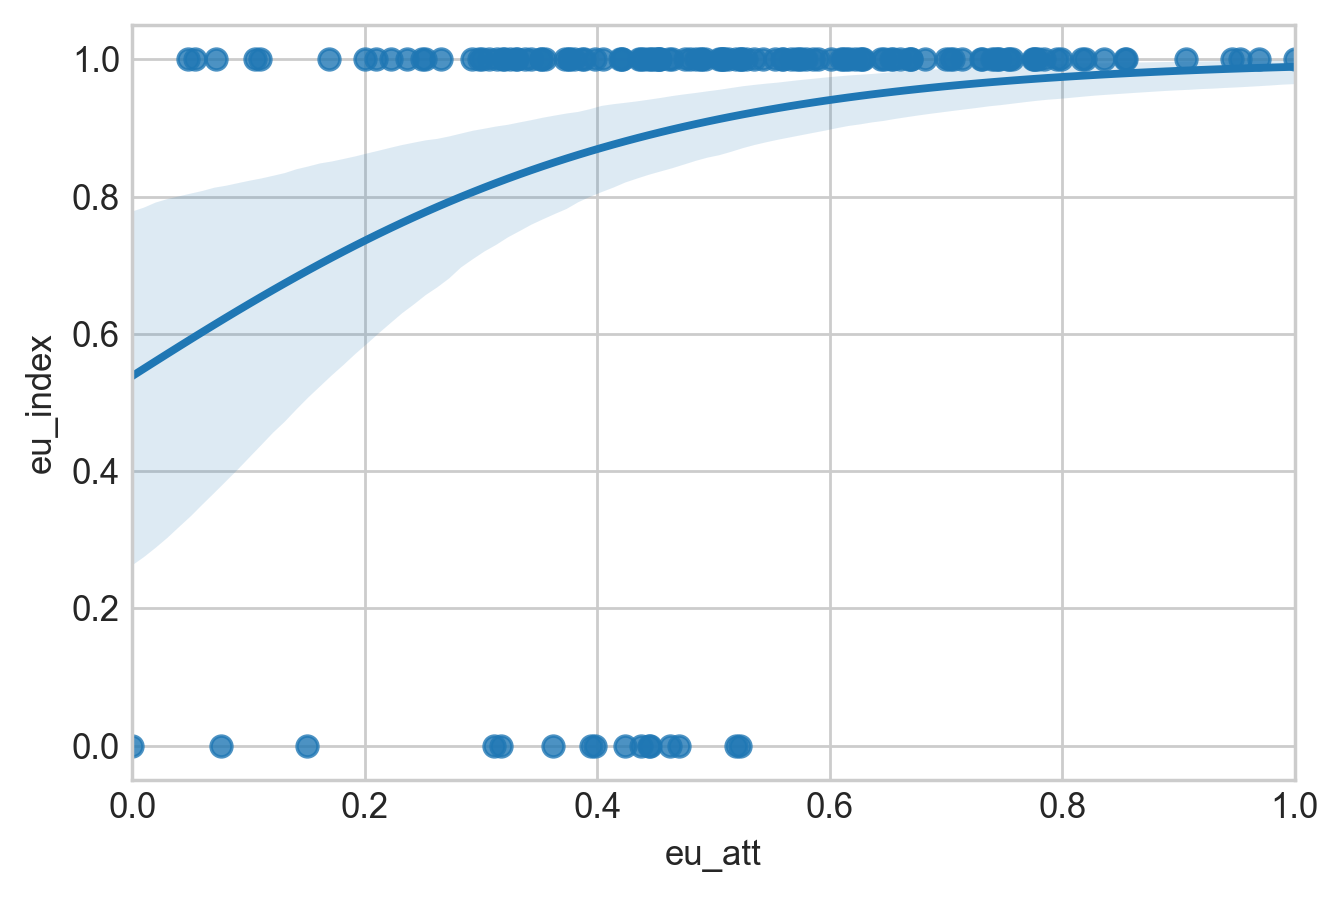

In [270]:
import seaborn as sns
sns.regplot(x='eu_att', y='eu_index', data=eu_val_sub, logistic=True)

## Candidate test validation (Politiken.dk)

In [271]:
df_politiken = pd.read_pickle('validation/politiken/df_politiken.p')

In [272]:
polvecs = pol2vec_model.document_vectors
polvecs.shape

(234, 300)

In [273]:
# project polvecs onto EU dimension
proj_dim = np.dot(polvecs, eu_axis)
proj_dim.shape

(234,)

In [345]:
eu_val = combined_hover.dropna()
eu_val['eu_att'] = proj_dim
eu_val['eu_att'] = rescale(eu_val['eu_att'])
eu_val.describe()

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,doc,rank,eu_att
count,234.000000,234.000000,234.000000
mean,116.500000,34.029915,0.045457
std,67.694165,17.411060,0.390472
min,0.000000,3.000000,-1.000000
25%,58.250000,16.000000,-0.214960
50%,116.500000,37.000000,0.021662
75%,174.750000,47.000000,0.317806
max,233.000000,55.000000,1.000000


In [346]:
eu_val_merged = eu_val.merge(df_politiken, left_on='full_name', right_on='fullname', how='inner')

In [347]:
eu_val_merged = eu_val_merged.drop(columns=['color']).merge(df_scales, left_on='full_name', right_on='fullname', how='inner')

In [348]:
# remove those with value 0 on dk_opt_out
eu_val_merged = eu_val_merged.loc[eu_val_merged['dk_opt_out'] != 0]
eu_val_merged = eu_val_merged.loc[eu_val_merged['dk_out_eu'] != 0]

In [349]:
eu_val_merged.shape

(125, 36)

In [350]:
eu_val_merged.head()

,doc,party_x,snippet,full_name,rank,eu_att,CandidateID,fullname_x,264,265,...,282,283,fullname_y,party_y,dk_out_eu,dk_up_def,dk_de_border,asyl_out_eu,color,index
0,0.0,DF,tak for det jeg er lidt forvirret på et højere...,Alex Ahrendtsen,37.0,0.080608,3946,Alex Ahrendtsen,5,1,...,1,1,Alex Ahrendtsen,DF,5.0,5.0,5.0,5.0,#265BA4,1.00
1,1.0,LA,tak for det og tak for den fine udtale af efte...,Alex Vanopslagh,13.0,0.189826,3876,Alex Vanopslagh,1,5,...,1,2,Alex Vanopslagh,LA,2.0,5.0,1.0,4.0,#E7B657,0.25
2,2.0,S,tak for ordet først og fremmest vil jeg sige t...,Anders Kronborg,55.0,-0.067827,3476,Anders Kronborg,2,1,...,3,4,Anders Kronborg,S,1.0,5.0,2.0,4.0,#C8042C,0.00
3,4.0,RV,tak for en rigtig god tale det var også godt d...,Andreas Steenberg,15.0,0.055256,3683,Andreas Steenberg,4,2,...,5,5,Andreas Steenberg,RV,1.0,4.0,1.0,1.0,#D82E8A,0.00
4,5.0,S,tak for det venstre er jo virkelig gode til fl...,Ane Halsboe-Jørgensen,55.0,0.818084,3477,Ane Halsboe-Jørgensen,3,1,...,3,4,Ane Halsboe-Jørgensen,S,1.0,5.0,4.0,5.0,#C8042C,0.00


In [416]:
# count number of times the strings 'eu' or 'union'  appear in snippet column
eu_val_merged['eu_count'] = eu_val_merged['snippet'].str.count('eu|union')

# Normalize eu_count col to between 0 and 1
eu_val_merged['eu_count'] = (eu_val_merged['eu_count'] - np.min(eu_val_merged['eu_count'])) / (np.max(eu_val_merged['eu_count']) - np.min(eu_val_merged['eu_count']))

In [417]:
# Potential weighting according to number of utterances
weight = parl_data['full_name'].value_counts()
eu_val_merged['weight'] = eu_val_merged['full_name'].map(weight)
eu_val_merged['weight'] = eu_val_merged['weight'] / eu_val_merged['weight'].sum()
eu_val_sub = eu_val_merged.loc[eu_val_merged['weight'] > 0]

In [418]:
eu_val_sub['eu_count'].describe()

count    125.000000
mean       0.087233
std        0.134125
min        0.000000
25%        0.016509
50%        0.045991
75%        0.104167
max        1.000000
Name: eu_count, dtype: float64

In [419]:
# Rescale eu_att and dk_opt_out to between -1, 1
eu_val_sub['dk_out_eu'] = rescale(eu_val_sub['dk_out_eu'])
eu_val_sub['dk_opt_out'] = rescale(eu_val_sub['dk_opt_out'])

print(eu_val_sub['dk_out_eu'].describe())
print(eu_val_sub['dk_opt_out'].describe())

count    125.00000
mean      -0.74000
std        0.56297
min       -1.00000
25%       -1.00000
50%       -1.00000
75%       -1.00000
max        1.00000
Name: dk_out_eu, dtype: float64
count    125.000000
mean       0.184000
std        0.670628
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: dk_opt_out, dtype: float64


In [420]:
# create scale of dk_opt_out and dk_out_eu
eu_val_sub['eu_index'] = (
    eu_val_sub['dk_opt_out'] #+
    #eu_val_sub['dk_out_eu']
) / 1

# reverse scale
eu_val_sub['eu_index'] = eu_val_sub['eu_index'].apply(lambda x: -x)

In [421]:
eu_val_sub['eu_index'].describe()

count    125.000000
mean      -0.184000
std        0.670628
min       -1.000000
25%       -1.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: eu_index, dtype: float64

In [422]:
# pearson correaltion between eu_val_sub['dk_opt_out'] and eu_val_sub['dk_out_eu']
from scipy.stats import pearsonr
pearsonr(eu_val_sub['dk_opt_out'], eu_val_sub['dk_out_eu'])

(0.5130789449406572, 9.481348476793893e-10)

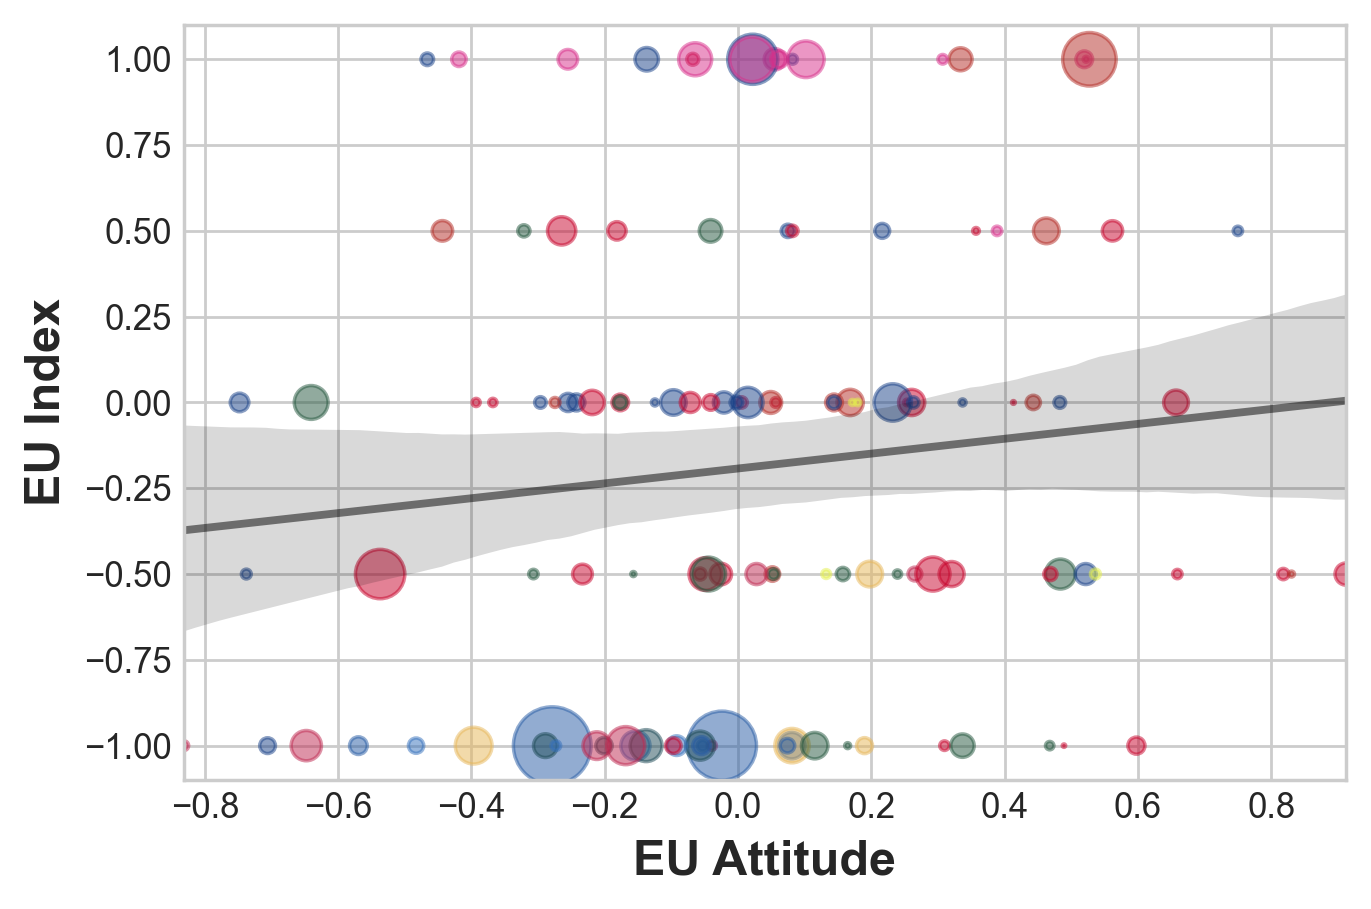

In [423]:
# scatterplot eu_att vs dk_opt_out using plt
plt.scatter(eu_val_sub['eu_att'], eu_val_sub['eu_index'], alpha=.5, color=eu_val_sub['color'], s=(eu_val_sub['eu_count']*500))

# add regression line
sns.regplot(x='eu_att', y='eu_index', data=eu_val_sub, scatter=False, color='black', line_kws={'alpha':.5})

# Add axis labs
plt.xlabel('EU Attitude', fontsize=14, weight='bold')
plt.ylabel('EU Index', fontsize=14, weight='bold')

plt.show()

In [424]:
eu_val_sub['eu_att'].describe()

count    125.000000
mean       0.038915
std        0.351607
min       -0.831655
25%       -0.176828
50%        0.022103
75%        0.263077
max        0.912416
Name: eu_att, dtype: float64

In [428]:
# run weighted least squares regression
import statsmodels.api as sm
X = rescale(eu_val_sub['eu_att'])
y = -eu_val_sub['dk_opt_out']
X = sm.add_constant(X)
model = sm.WLS(y, X, weights=eu_val_sub['eu_count']).fit()
predictions = model.predict(X)

# Print out the statistics
model.summary()

/Users/mathiasbruun/me/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:778: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             dk_opt_out   R-squared:                       0.097
Model:                            WLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     13.25
Date:                Sun, 07 May 2023   Prob (F-statistic):           0.000400
Time:                        11:54:09   Log-Likelihood:                   -inf
No. Observations:                 125   AIC:                               inf
Df Residuals:                     123   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1966      0.067     -2.953      0.004      -0.328      -0.065
eu_att         0.6509      0.179      3.640      0.000       0.297       1.005
==============================================================================
Omnibus:                       18.214   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.528
Skew:                           0.608   Prob(JB):                     1.93e-08
Kurtosis:                       5.311   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [426]:
# output model to latex table
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &   dk\_opt\_out   & \textbf{  R-squared:         } &     0.097   \\
\textbf{Model:}            &       WLS        & \textbf{  Adj. R-squared:    } &     0.090   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     13.25   \\
\textbf{Date:}             & Sun, 07 May 2023 & \textbf{  Prob (F-statistic):} &  0.000400   \\
\textbf{Time:}             &     10:46:32     & \textbf{  Log-Likelihood:    } &      -inf   \\
\textbf{No. Observations:} &         125      & \textbf{  AIC:               } &       inf   \\
\textbf{Df Residuals:}     &         123      & \textbf{  BIC:               } &       inf   \\
\textbf{Df Model:}         &           1      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                 & \textbf{coef} & \tex